In [9]:
import matplotlib.pyplot as plt
from pylab import imshow, figure, plot, colorbar, show, hist
%matplotlib inline

import json
import glob
import numpy as np

In [2]:
filenames = glob.glob('snap/*.log.json')

In [7]:
def plot_compare(filenames, metric='acc', smoothing=1):
    figure(figsize=(10,7))
    for f in sorted(filenames):
        #print(f)
        with open(f, 'r') as fh:
            try:
                log = json.load(fh)
                label = f.replace('snap/config_', '').replace('.log.json', '')
                label += " " + log["version"]
                v = log[metric]
                if smoothing != 1:
                    v = np.convolve(v, np.ones((smoothing,))/smoothing, mode='valid')
                plot(v, label=label)
            except Exception as e:
                print(str(e))
    if metric == 'acc': plt.ylim(0.99,1)
    if metric == 'fpr': plt.ylim(0,0.001)
    #plt.xlim(0,100)

    plt.legend()
    show()

## Which optimizer?

Results: 

- adam - best, slightly better than nadam
- nadam - good
- rmsprop - good, maybe haven't run for long enough to tell
- sgd - worst

Note: adam seems to need ~75-125 epochs at lr=0.001

Note: rmsprop sometimes has fpr=0 very early on


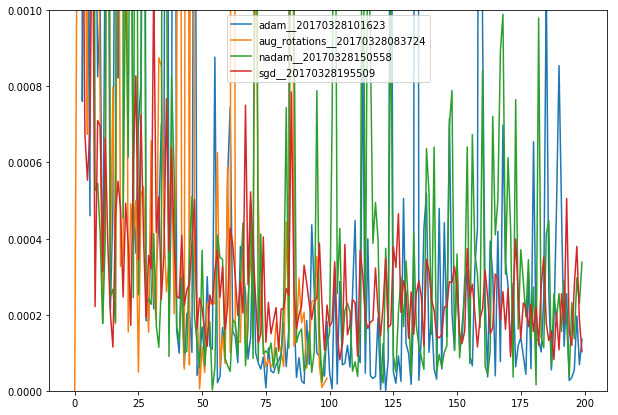

In [67]:
plot_compare(['snap/config_adam__20170328101623.log.json',
              'snap/config_nadam__20170328150558.log.json', 
              'snap/config_sgd__20170328195509.log.json',
              'snap/config_aug_rotations__20170328083724.log.json' # rmsprop
             ], 'fpr')

## What learning rate?

lr 0.001 is better than 0.0001 is (much) better than 0.00001

best results around 50-150 epochs for all

Try: even higher lr

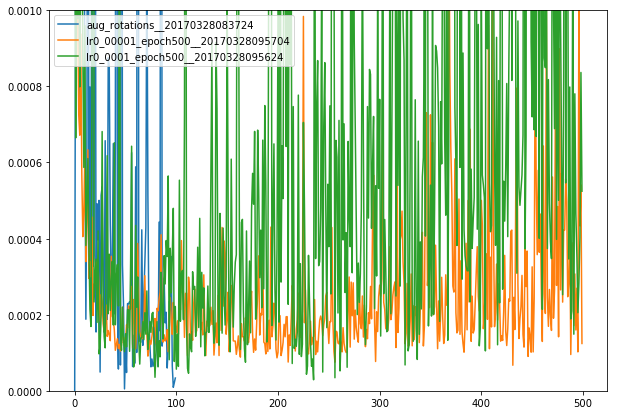

In [83]:
 plot_compare(['snap/config_aug_rotations__20170328083724.log.json', # lr 0.001
               'snap/config_lr0_0001_epoch500__20170328095624.log.json',
               'snap/config_lr0_00001_epoch500__20170328095704.log.json'], 'fpr')


## BN before or after activation?

- f6b936 snap/config_relu_after_bn__20170328225512.log.json 15-layer bn before activation
- 33b7df snap/config_layers15__20170328224101.log.json 15-layer bn after activation

Results: before bn is clear winner, fpr much less noisy, acc higher

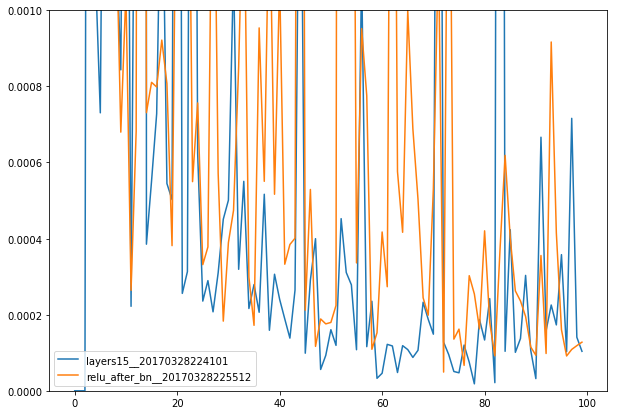

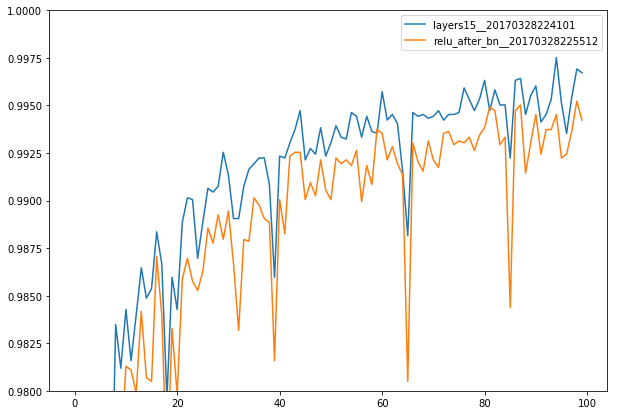

In [68]:
plot_compare(['snap/config_relu_after_bn__20170328225512.log.json',
'snap/config_layers15__20170328224101.log.json'], 'fpr')

plot_compare(['snap/config_relu_after_bn__20170328225512.log.json',
'snap/config_layers15__20170328224101.log.json'], 'acc')

## Dropout+BN or just BN?

Dropout seems a bit better

Note: these all used the 10-layer, relu after BN architecture which is less good. Worth rerunning with relu before BN?



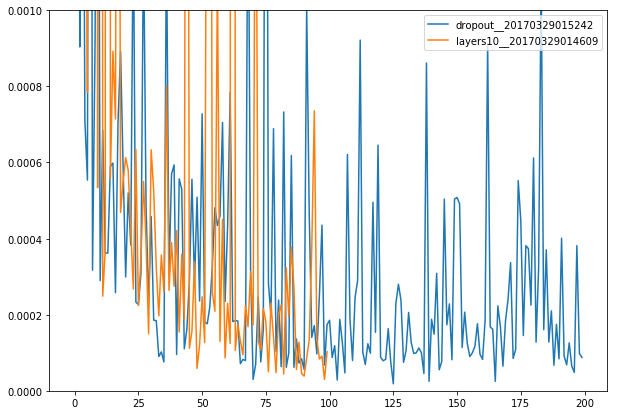

In [87]:
plot_compare(['snap/config_dropout__20170329015242.log.json',
              'snap/config_layers10__20170329014609.log.json' # BN only
             ],  
             'fpr')

## Augment with rotation vs no rotation?

Results: with rotations seems to be the clear winner, localizer fpr is consistently lower

Note: some nodules were excluded from run with rotations because they don't produce (unpadded) 64x cubes

Note: worth re-running?


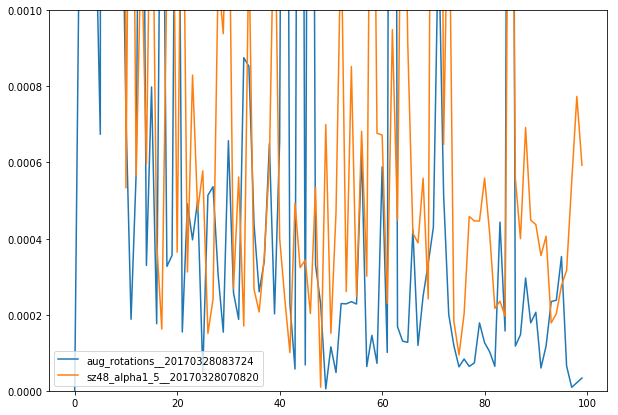

In [69]:
plot_compare(['snap/config_sz48_alpha1_5__20170328070820.log.json',
  'snap/config_aug_rotations__20170328083724.log.json'], 'fpr')

## Depth: 10, 15, 18 layers?


Filling in extra layers as 1x1 convolutions in between 3x3s

Results: 18 is significantly better, 10 and 15 are approx tied

Note: these all used the relu after BN architecture which is less good.  Worth rerunning with relu before BN?

Note: number of params differs relatively little between all of these

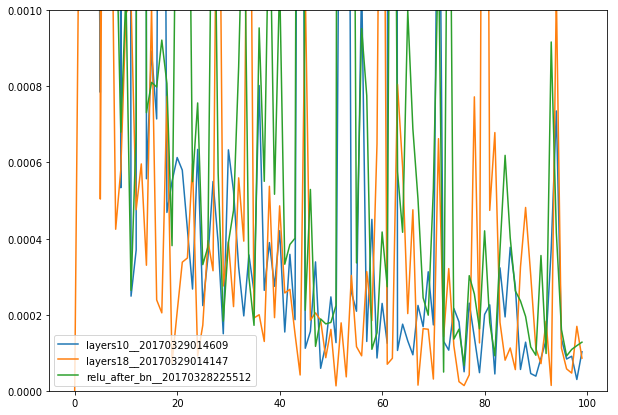

In [76]:
plot_compare(['snap/config_layers10__20170329014609.log.json',
 'snap/config_relu_after_bn__20170328225512.log.json', # 15 layers
 'snap/config_layers18__20170329014147.log.json'], 'fpr')


## Layer map size and growth rate / alpha

sz128_alpha1_5 wins overall

At alpha=1.5, sz128 > sz96 > sz32 > sz48

sz128 with low growth rate > sz32 with high growth rate

More params is always better: are these nets even large _enough_?



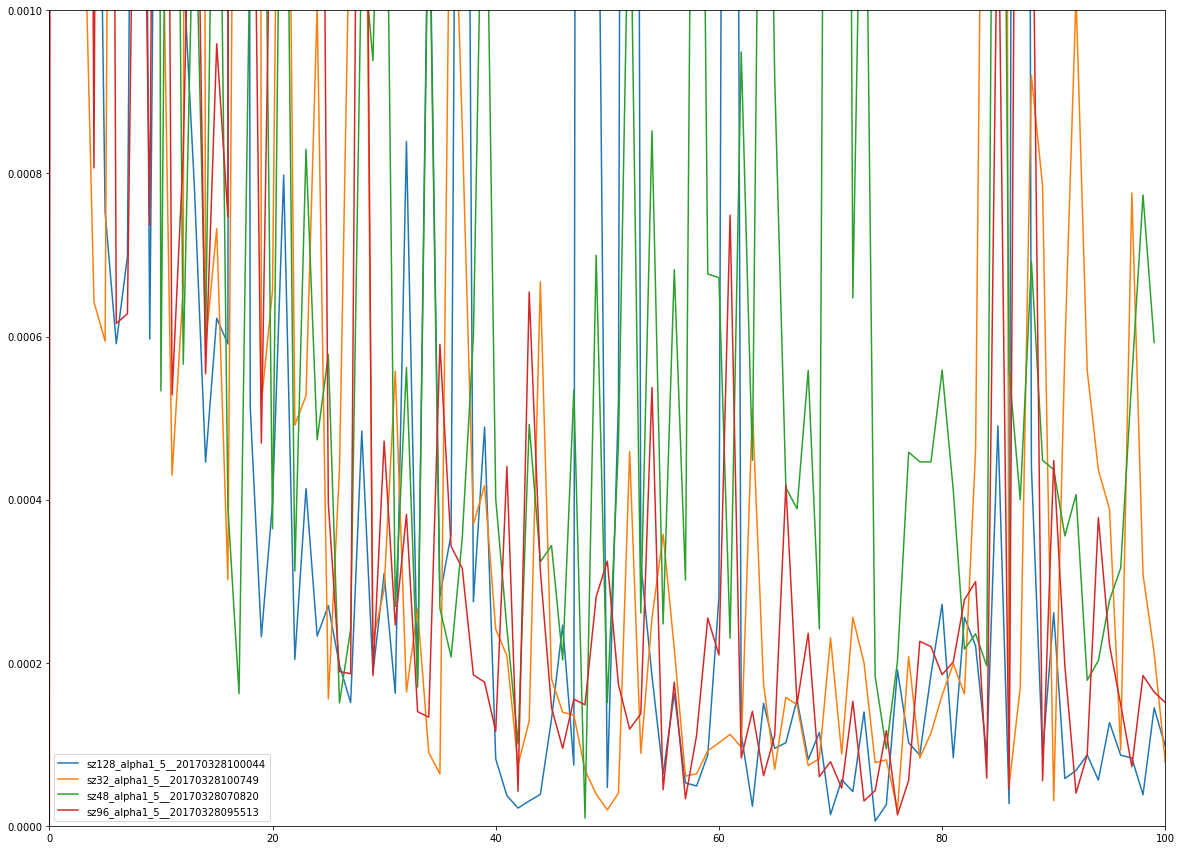

In [98]:
plot_compare([
'snap/config_sz32_alpha1_5__20170328100749.log.json',
 'snap/config_sz48_alpha1_5__20170328070820.log.json',
 'snap/config_sz96_alpha1_5__20170328095513.log.json',
 'snap/config_sz128_alpha1_5__20170328100044.log.json'
], 'fpr')

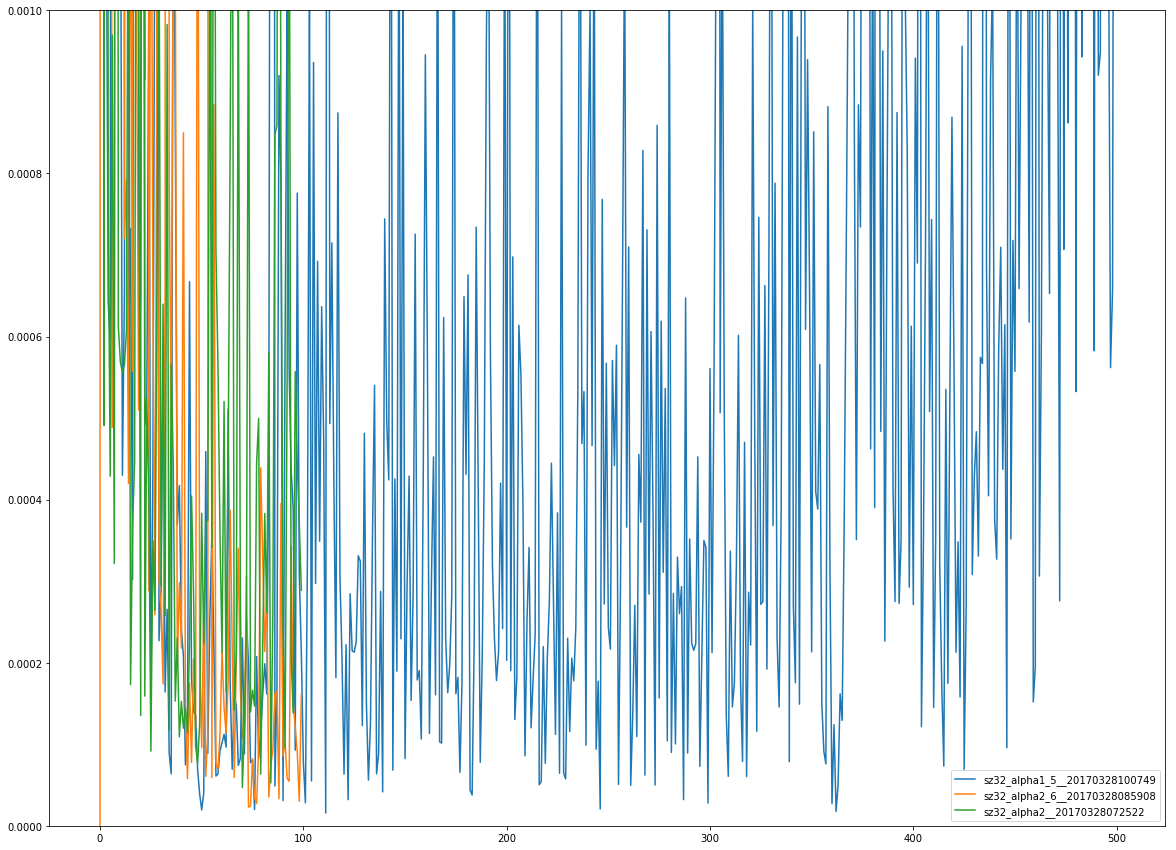

In [104]:
plot_compare([
 'snap/config_sz32_alpha1_5__20170328100749.log.json',
 'snap/config_sz32_alpha2__20170328072522.log.json',
 'snap/config_sz32_alpha2_6__20170328085908.log.json',
], 'fpr')

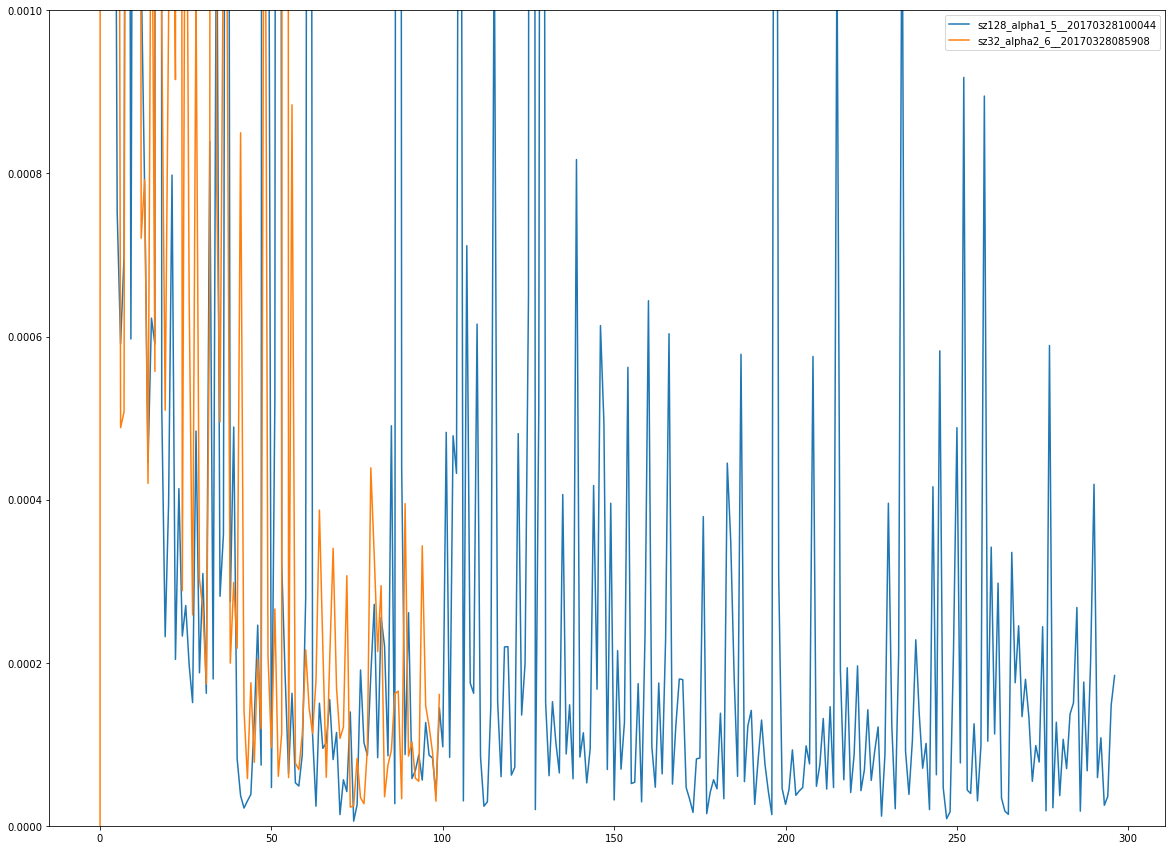

In [103]:
plot_compare([
 'snap/config_sz32_alpha2_6__20170328085908.log.json',
 'snap/config_sz128_alpha1_5__20170328100044.log.json'
], 'fpr')

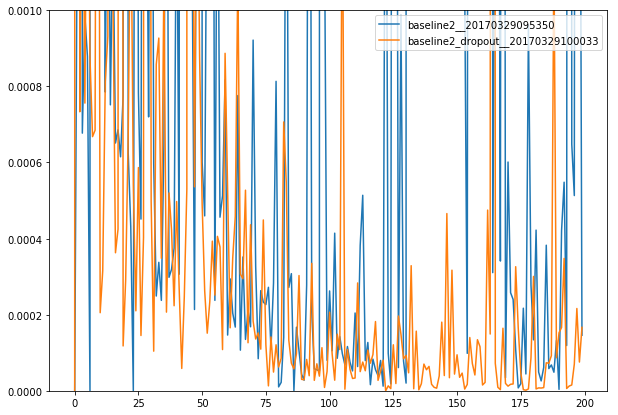

In [126]:
plot_compare([
'snap/config_baseline2__20170329095350.log.json',
'snap/config_baseline2_dropout__20170329100033.log.json'
], 'fpr')

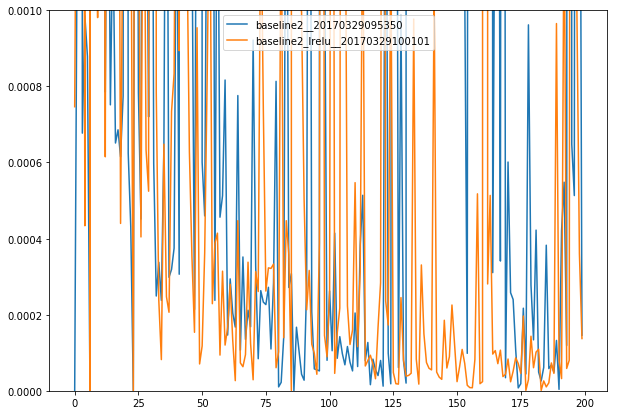

In [128]:
plot_compare([
'snap/config_baseline2__20170329095350.log.json',
'snap/config_baseline2_lrelu__20170329100101.log.json'
], 'fpr')

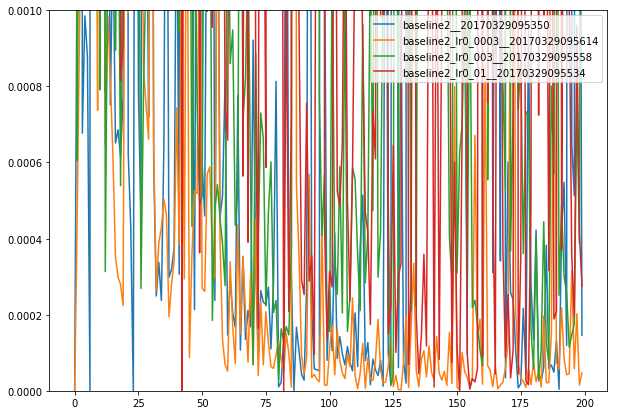

In [133]:
plot_compare([
'snap/config_baseline2_lr0_0003__20170329095614.log.json',
'snap/config_baseline2__20170329095350.log.json', # lr=0.001
'snap/config_baseline2_lr0_003__20170329095558.log.json',
'snap/config_baseline2_lr0_01__20170329095534.log.json'
], 'fpr')

In [119]:
fprs = []
epochs = []
fs = []
p_lol = []

for f in sorted(filenames):
    with open(f, 'r') as fh:
        try:
            log = json.load(fh)
            fprs += log['fpr']
            epochs += range(len(log['fpr']))
            fs += [ f for n in range(len(log['fpr'])) ]
            p_lol += log['p_list']
        except Exception as e:
            print(str(e))


Expecting value: line 1 column 619 (char 618)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 80 (char 79)
Expecting value: line 1 column 80 (char 79)


In [120]:
fprs = np.asarray(fprs)

In [121]:
import numpy as np

In [134]:
for idx in np.argsort(fprs)[:30]:
    print(fs[idx], epochs[idx], fprs[idx], ['%.2f'%x for x in sorted(p_lol[idx])][:10])

snap/config_layers15__20170328224101.log.json 2 0.0 ['0.00', '0.00', '0.00', '0.00', '0.02', '0.34', '0.73', '0.99', '1.00', '1.00']
snap/config_baseline2__20170329095350.log.json 0 0.0 ['0.00', '0.00', '0.83', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']
snap/config_sz96_alpha1_5__20170328095513.log.json 0 0.0 ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.10', '0.12', '0.96', '0.98']
snap/config_baseline2__20170329095350.log.json 23 0.0 ['0.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00', '1.00']
snap/config_layers18__20170329014147.log.json 0 0.0 ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1.00', '1.00', '1.00']
snap/config_layers15__20170328224101.log.json 1 0.0 ['0.00', '0.00', '0.00', '0.00', '0.00', '0.11', '0.66', '0.95', '1.00', '1.00']
snap/config_baseline2_dropout__20170329100033.log.json 122 0.0 ['0.01', '0.02', '0.06', '0.08', '0.09', '0.12', '0.12', '0.19', '0.25', '0.65']
snap/config_baseline2_lr0_0003__20170329095614.log

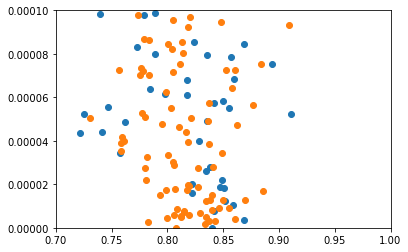

In [163]:
for f in sorted(['snap/config_baseline2__20170329095350.log.json', 
                 'snap/config_baseline2_dropout__20170329100033.log.json',
                #'snap/config_baseline2_lr0_0003__20170329095614.log.json'
                ]):
    with open(f, 'r') as fh:
        log = json.load(fh)
        log['p_threshold'] = np.asarray(log['p_threshold'])
        log['p_list_mean'] = np.asarray([ np.mean(x) for x in log['p_list'] ])
        log['fpr'] = np.asarray(log['fpr'])
        s = slice(50,200,None)
        #idxs = np.argsort(log['p_threshold'][s])
        #plt.scatter(log['p_threshold'][s][idxs], log['fpr'][s][idxs])
        idxs = np.argsort(log['p_list_mean'][s])
        plt.scatter(log['p_list_mean'][s][idxs], log['fpr'][s][idxs])
        plt.ylim(0,0.0001)
        plt.xlim(0.7,1.0)

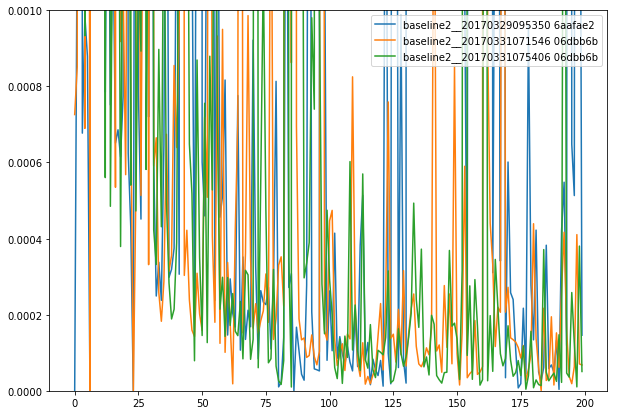

In [15]:


plot_compare([
 'snap/config_baseline2__20170331071546.log.json', # incorrect -> leaky relu
 'snap/config_baseline2__20170331075406.log.json', # binary crossentropy?  incorrect -> leaky relu
 'snap/config_baseline2__20170329095350.log.json', # original pre-bugfix
], 'fpr')